# Pairwise Spectral EMD Example

Example code to load in events and calculate their pairwise spectral EMDs. Takes about 15 seconds to compile + 30 seconds to run on my laptop, assuming the dataset is already downloaded (Approx 11000 pairs per minute) uing the default presets in this notebook. The more memory, the merrier.

Before using, make sure to `pip install .` in the root directory of this repository.

In [1]:
from pyspecter.SPECTER import SPECTER

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import initialize, newplot
initialize()


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time

2023-10-27 11:53:42.881141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Load Dataset

In [2]:
# CMS Open Sim Parameters
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 75 # Note that runtime is pad^2, memory is pad^4

n_samples = 100
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

# Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
dataset, sim_weights, k_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta_cut, quality, pad = pad, n = n_samples, )
weights = sim_weights * k_factors



Max # of particles: 113


# Set up SPECTER

In [3]:
# Set up and compile SPECTER
specter = SPECTER(compile = True)


Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  1.5266904830932617  seconds.
Compiling observables...
Observables compiled! Time taken:  1.526738166809082  seconds.
Compiling spectral representation functions ...
Compilation complete! Time taken:  27.817737340927124  seconds.


# Compute EMDs
Compute the EMDs between every pair of events, in parallel batches of `batch_size` events.

In [4]:
# Get list of pairwise indices
i_pairs, j_pairs = np.triu_indices(n_samples, k = 1)

# Initialize matrix to store pairwise EMDs
pairwise_emds = np.zeros((n_samples, n_samples))

# Compute batches
start_time = time.time()
for n in range(0, len(i_pairs), batch_size):

    print(f"Computing Batch {n}-{n+batch_size} of {len(i_pairs)} pairs. Elapsed Time: {time.time() - start_time :.3f} seconds")
    i_batch = i_pairs[n : n + batch_size]
    j_batch = j_pairs[n : n + batch_size]
    
    # Compute the pairwise EMDs
    emds = specter.spectralEMD(dataset[i_batch], dataset[j_batch])
    
    # Store the results
    pairwise_emds[i_batch, j_batch] = emds
    pairwise_emds[j_batch, i_batch] = emds

print(f"Done! Total Elapsed Time: {time.time() - start_time :.3f} seconds")

Computing Batch 0-1 of 4950 pairs. Elapsed Time: 0.000 seconds
Computing Batch 1-2 of 4950 pairs. Elapsed Time: 1.677 seconds
Computing Batch 2-3 of 4950 pairs. Elapsed Time: 1.679 seconds
Computing Batch 3-4 of 4950 pairs. Elapsed Time: 1.682 seconds
Computing Batch 4-5 of 4950 pairs. Elapsed Time: 1.684 seconds
Computing Batch 5-6 of 4950 pairs. Elapsed Time: 1.686 seconds
Computing Batch 6-7 of 4950 pairs. Elapsed Time: 1.688 seconds
Computing Batch 7-8 of 4950 pairs. Elapsed Time: 1.690 seconds
Computing Batch 8-9 of 4950 pairs. Elapsed Time: 1.693 seconds
Computing Batch 9-10 of 4950 pairs. Elapsed Time: 1.695 seconds
Computing Batch 10-11 of 4950 pairs. Elapsed Time: 1.697 seconds
Computing Batch 11-12 of 4950 pairs. Elapsed Time: 1.699 seconds
Computing Batch 12-13 of 4950 pairs. Elapsed Time: 1.702 seconds
Computing Batch 13-14 of 4950 pairs. Elapsed Time: 1.704 seconds
Computing Batch 14-15 of 4950 pairs. Elapsed Time: 1.706 seconds
Computing Batch 15-16 of 4950 pairs. Elapsed

Text(0, 0.5, 'Density')

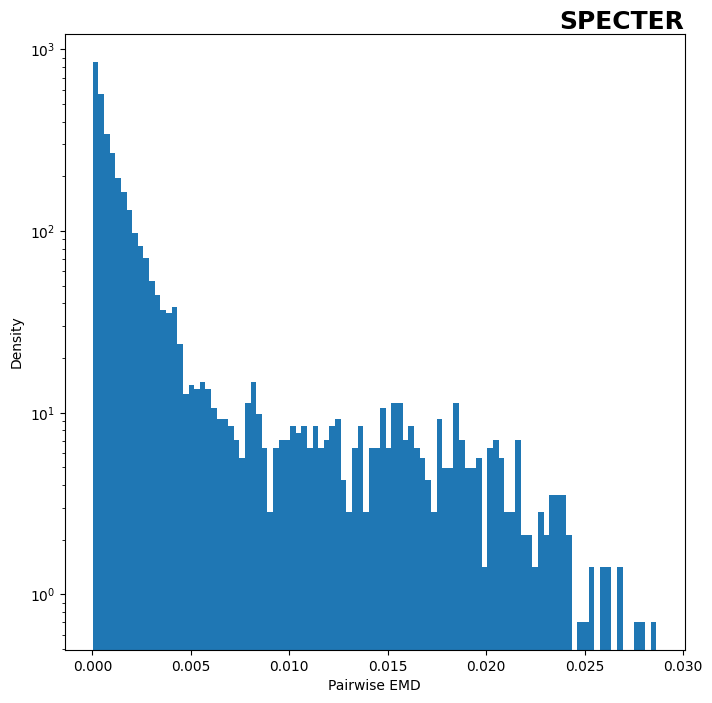

In [5]:
# Histogram the results (upper triangle only)
newplot()
plt.hist(pairwise_emds[np.triu_indices(n_samples, k = 1)], bins = 100, density=True)
plt.yscale("log")
plt.xlabel("Pairwise EMD")
plt.ylabel("Density")
